# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

Para este proyecto se realizará un breve análisis del comportamiento temporal de los datos recibidos. Posteriormente, se prepararán las características necesarias para entrenar los modelos de aprendizaje automático y, finalmente, se evaluará el rendimiento obtenido por cada modelo.  


Como primer paso indispensable, se cargan todas las librerías utilizadas a lo largo del proyecto en una celda dedicada para ello. Estas librerías se encuentran organizadas según las diferentes etapas del proceso de implementación. 

In [53]:
# Librerías de manipulación de datos
import pandas as pd
import numpy as np

# Librerías para análisis de datos
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Librerías para procesamiento de datos orientado a ML
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Librerías de ML y evaluación
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

Comenzamos leyendo el archivo taxi.csv. A continuación, mostramos la estructura del dataframe y las primeras cinco filas con el propósito de verificar los elementos, sus tipos de datos y su coherencia.

In [54]:
# Lectura del dataset
taxi = pd.read_csv('taxi.csv')

# Estructura del dataframe y las 5 primeras líneas
print(taxi.info())
display(taxi.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB
None


,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


El resultado nos permite observar que existen únicamente dos columnas: **fecha** y **número de órdenes**. También podemos notar que no hay valores ausentes y que la columna de fechas aún no tiene un formato de fecha adecuado.
Como siguiente paso, asignamos el tipo de dato correcto a las fechas y las convertimos en el índice del dataframe. Este ajuste es necesario porque trabajaremos con una serie temporal y su análisis y manipulación resultan más ágiles cuando las fechas están correctamente definidas como índice.

In [ ]:
# Asignación de formato datetime y conversión a indices
taxi['datetime'] = pd.to_datetime(taxi['datetime'])
taxi = taxi.set_index('datetime')
display(taxi.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Análisis

Como primer paso del análisis, corroboramos que los datos estén ordenados cronológicamente y que la serie tenga una frecuencia uniforme. Otra medida que se tomó fue encontrar en que fecha comienzan los registros y en que fecha finalizan para poder usar los meses registrados como recurso de análisis. Posteriormente, se grafica 

Tiene orden cronológico: True


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-08-31 23:50:00,53


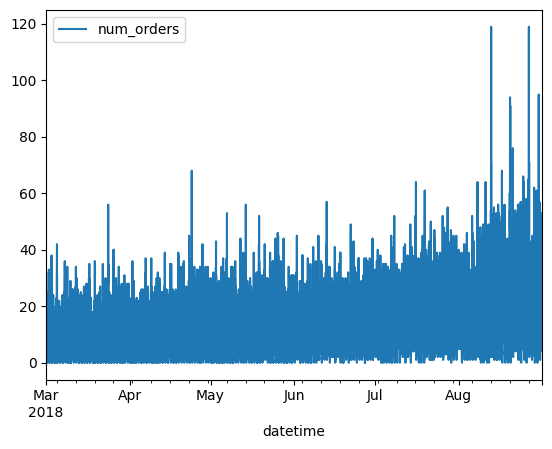

In [ ]:
# Verificación del orden cronológico y uniformidad
print(f"Tiene orden cronológico: {taxi.index.is_monotonic_increasing}")
display(taxi.iloc[[0,-1]])
taxi.plot()
plt.show()

La gráfica original presenta demasiado ruido y resulta difícil de interpretar. Por ello, aplicamos un remuestreo con intervalos de una hora utilizando la suma de las órdenes en cada intervalo. A continuación, generamos una gráfica que muestra el comportamiento de la serie en un rango de cinco días con el remuestreo aplicado.

<Axes: xlabel='datetime'>

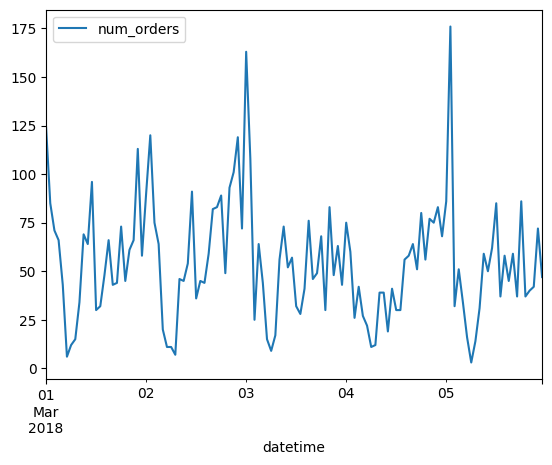

In [ ]:
# Muestra de resample en periodo de 5 días
taxi = taxi.resample('1h').sum()
taxi['2018-03-01':'2018-03-05'].plot()

Ahora nos centraremos en el análisis de los componentes temporales del dataset. Aplicamos el método `seasonal_decompose()` para obtener la tendencia, la estacionalidad y el residuo. Luego, generamos una gráfica para cada componente y las presentamos en una disposición vertical para facilitar su interpretación.

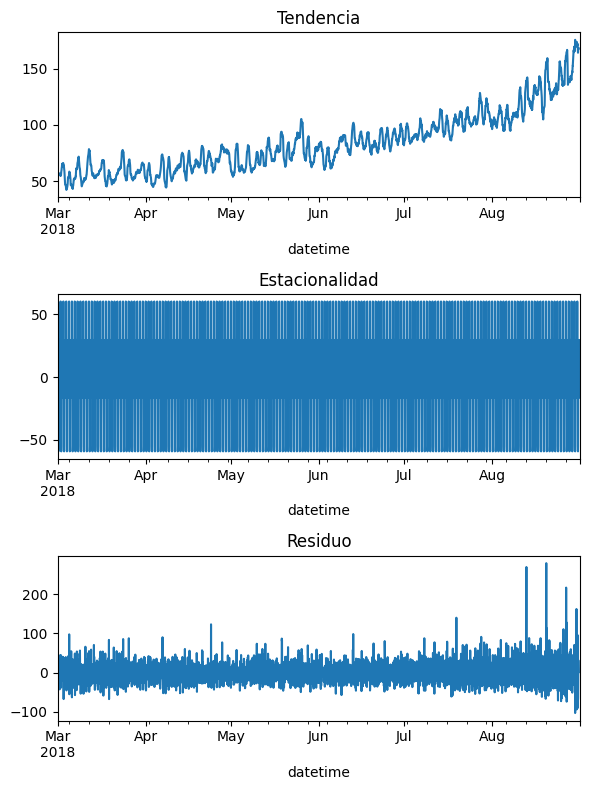

In [ ]:
# Gráficas de los componentes del método seasonal_decompose
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuo')
plt.tight_layout()

Debido a la cantidad de datos, la descomposición completa de la serie puede resultar difícil de interpretar. Por ello, aplicamos `seasonal_decompose()` sobre un rango de tiempo más reducido. Al igual que en la celda anterior, generamos una visualización en disposición vertical para un intervalo de quince días.

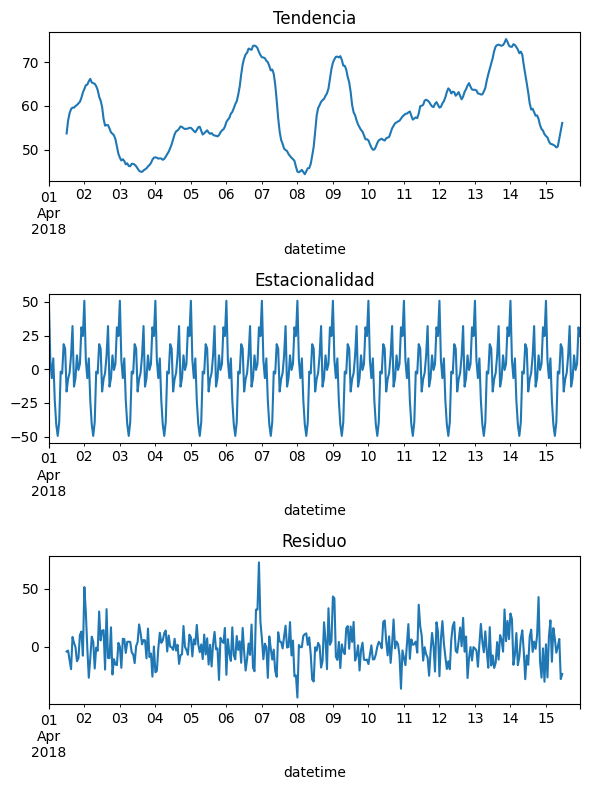

In [ ]:
# Gráficas de los componentes del método seasonal_decompose para un periodo más corto

decomposed = seasonal_decompose(taxi['2018-04-01':'2018-04-15'])
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuo')
plt.tight_layout()

Con ambos recursos visuales podemos interpretar el comportamiento de las componentes obtenidas. En el conjunto completo se observa una tendencia al alza, una estacionalidad aparente y un residuo de baja magnitud. En el rango reducido, se distinguen periodos con tendencia al alza y otros a la baja, se aprecia con mayor claridad la estacionalidad de la serie y se confirma que el ruido es bajo.  
Finalmente, utilizamos el método `describe()` para obtener la distribución estadística de los datos, lo cual nos sirve como referencia al momento de evaluar el rendimiento de los modelos de aprendizaje automático.

In [ ]:
# Impresión de la distribución de los datos
print(taxi.describe())

        num_orders
count  4416.000000
mean     84.422781
std      45.023853
min       0.000000
25%      54.000000
50%      78.000000
75%     107.000000
max     462.000000


## Formación

Para poder predecir la serie temporal será necesario aplicar ingeniería de características. Para ello, creamos una función que devuelve un dataframe con las características planificadas. Estas características incluyen variables de calendario, valores rezagados (lags) desde rangos de horas hasta días completos, la diferencia entre los valores de hace 48 horas y una serie de medias móviles calculadas en ventanas de horas y días.

In [ ]:
# Función de creación de características
def make_features(df, lag_list, rolling_mean_list):
    # Datos de calendario
    data = df.copy()
    data['month'] = data.index.month
    data['week_of_month'] = data.index.day // 7
    data['dayofweek'] = data.index.dayofweek
    data['weekend'] = data.index.dayofweek.isin([5,6]).astype(int)
    data['time'] = data.index.hour
    data['diff_48'] = data['num_orders'].shift(24) - data['num_orders'].shift(48)

    # Creación de lags
    for lag in lag_list:
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Creación de rolling means
    for window in rolling_mean_list:
        data['rolling_mean_{}'.format(window)] = (data['num_orders'].shift().rolling(window).mean())
        
    return data

Llamamos a la función de creación de características y le proporcionamos los parámetros necesarios.

In [ ]:
# Listas de valores para lags y rolling means
lag_list = [1,2,3,4,5,6,24,48,72,96,167,168,169]
rolling_mean_list = [3, 6, 24, 48, 168]

# Llamada de la función creadora de características
taxis_new = make_features(taxi, lag_list=lag_list, rolling_mean_list=rolling_mean_list)
display(taxis_new.head())

,num_orders,month,week_of_month,dayofweek,weekend,time,diff_48,lag_1,lag_2,lag_3,...,lag_72,lag_96,lag_167,lag_168,lag_169,rolling_mean_3,rolling_mean_6,rolling_mean_24,rolling_mean_48,rolling_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,3,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,0,3,0,1,NaN,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,0,3,0,2,NaN,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,0,3,0,3,NaN,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,93.333333,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,0,3,0,4,NaN,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,74.000000,NaN,NaN,NaN,NaN


Para finalizar la etapa de creación de características, dividimos el dataframe en conjuntos de entrenamiento y prueba, evitando mezclar el orden temporal de los datos. Para ello utilizamos una proporción de 4:1. Finalmente, asignamos las características a la variable correspondiente y definimos cuál será el target del modelo.

In [ ]:
# División de los datos para training y test
train, test = train_test_split(taxis_new, shuffle=False, test_size=0.2)
train = train.dropna()

# Asignación de features y target
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']
features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

## Prueba

El primer modelo que se entrenó fue la regresión lineal. La única consideración adicional fue aplicar el escalado de las características mediante un pipeline. Posteriormente, el modelo fue entrenado y evaluado.

In [65]:
pipeline_lr = Pipeline([('scaler', RobustScaler()), ('model', LinearRegression())])
pipeline_lr.fit(features_train, target_train)
predict_valid_lr = pipeline_lr.predict(features_test)

print("RMSE:",np.sqrt(mean_squared_error(target_test, predict_valid_lr)))

RMSE: 32.65408867109123


El segundo modelo utilizado fue Random Forest. En este caso no se requirieron consideraciones adicionales en la preparación de los datos. Se realizó una exploración moderada de hiperparámetros con el fin de obtener la mejor puntuación posible.

In [66]:
model_rf = RandomForestRegressor(
    n_estimators=60, 
    max_depth=10, 
    min_samples_leaf=2,
    min_samples_split=5,
    random_state=9732
)
model_rf.fit(features_train, target_train)
predict_valid_rf = model_rf.predict(features_test)

print("RMSE:",np.sqrt(mean_squared_error(target_test, predict_valid_rf)))

RMSE: 37.024830198787974


El tercer modelo utilizado fue LightGBM. En este caso tampoco se requirieron consideraciones adicionales en la preparación de los datos. Se realizó una exploración moderada de hiperparámetros con el fin de obtener la mejor puntuación posible.

In [67]:
model_lgbm = LGBMRegressor(
    objective='regression',
    n_estimators=500, 
    learning_rate=0.01,
    max_depth=5,
    random_state=9732,
    verbose=-1
)
model_lgbm.fit(features_train, target_train)
predict_valid_lgbm = model_lgbm.predict(features_test)

print("RMSE:",np.sqrt(mean_squared_error(target_test, predict_valid_lgbm)))

RMSE: 37.61899049830331


El cuarto y último modelo utilizado fue Catboost. En este caso tampoco se requirieron consideraciones adicionales en la preparación de los datos. Se realizó una exploración moderada de hiperparámetros con el fin de obtener la mejor puntuación posible.

In [68]:
model_cat = CatBoostRegressor(
    loss_function="RMSE", 
    learning_rate=0.01, 
    iterations=800, 
    max_depth=4,
    random_seed=9732,
    verbose=0
)
model_cat.fit(features_train, target_train)
predict_valid_cat = model_cat.predict(features_test)

print("RMSE:",np.sqrt(mean_squared_error(target_test, predict_valid_cat)))

RMSE: 38.38532318103207


Para establecer un punto de referencia, se construyeron dos modelos baseline. El primero utiliza la mediana de los valores del conjunto de entrenamiento como predicción constante y se evaluó para medir su desempeño. El segundo corresponde al método de persistencia, en el que cada valor se pronostica usando el dato inmediato anterior. Ambos modelos sirven como referencia mínima: los modelos de machine learning deben superar su rendimiento para considerarse buenos predictores.

In [ ]:
pred_median = np.ones(target_test.shape) * target_test.median()
pred_previous = target_test.shift()
pred_previous.iloc[0] = target_test.iloc[-1]
print("RMSE con mediana:",np.sqrt(mean_squared_error(target_test, pred_median)))
print("RMSE con valor anterior:",np.sqrt(mean_squared_error(target_test, pred_previous)))

RMSE con mediana: 54.84898024105975
RMSE con valor anterior: 53.42502252385307


Imprimimos todas las puntuaciones en una misma linea para poder comparar más fácil.

In [71]:
print("Comparativa de las puntuaciones obtenidas de diferentes modelos")
print("LinearRegressor RMSE:",np.sqrt(mean_squared_error(target_test, predict_valid_lr)))
print("RandomForestRegressor RMSE:",np.sqrt(mean_squared_error(target_test, predict_valid_rf)))
print("LGBMRegressor RMSE:",np.sqrt(mean_squared_error(target_test, predict_valid_lgbm)))
print("CatBoostRegressor RMSE:",np.sqrt(mean_squared_error(target_test, predict_valid_cat)))
print("Predicción por mediana RMSE:",np.sqrt(mean_squared_error(target_test, pred_median)))
print("Predicción persistente RMSE:",np.sqrt(mean_squared_error(target_test, pred_previous)))

Comparativa de las puntuaciones obtenidas de diferentes modelos
LinearRegressor RMSE: 32.65408867109123
RandomForestRegressor RMSE: 37.024830198787974
LGBMRegressor RMSE: 37.61899049830331
CatBoostRegressor RMSE: 38.38532318103207
Predicción por mediana RMSE: 54.84898024105975
Predicción persistente RMSE: 53.42502252385307


### Conclusión
En conclusión, el modelo de regresión lineal obtuvo la mejor puntuación entre todos los modelos evaluados. Este resultado sugiere que la relación entre las características creadas y el número de pedidos presenta un comportamiento predominantemente lineal. Además, todos los modelos superaron claramente el desempeño de los modelos baseline (predicción constante y método de persistencia). Finalmente, la regresión lineal alcanzó errores inferiores a la propia desviación estándar del conjunto de datos, lo que confirma su eficacia como predictor en este problema.